### SOME NOTES

- To improve performance, check https://svail.github.io/rnn_perf/

    - For readers in first group (users of deep learning frameworks) - the main takeaway is to make layer sizes and mini-batch sizes multiples of 32, and if you're using cuBLAS, then make them multiples of 64 for best performance. If you're writing recurrent layers yourself, make sure to write them in such a way that you combine across time when possible. 
    
- Try to hyperparameter optimization: http://maxpumperla.com/hyperas/

- SincNet can be helpful. https://github.com/mravanelli/SincNet/

- Check the transformer. https://jalammar.github.io/illustrated-transformer/ https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html http://nlp.seas.harvard.edu/2018/04/03/attention.html

- Autokeras. https://github.com/jhfjhfj1/autokeras

- Should we use FeedForward? https://www.offconvex.org/2018/07/27/approximating-recurrent/

- TCN https://github.com/philipperemy/keras-tcn

- Another method for speaker change detection https://github.com/philipperemy/speaker-change-detection

- Rare sound event detection: https://www.cs.tut.fi/sgn/arg/dcase2017/documents/challenge_technical_reports/DCASE2017_Lim_204.pdf

- We can augment data via [Pydub](https://github.com/jiaaro/pydub). https://towardsdatascience.com/tensorflow-speech-recognition-challenge-solution-outline-9c42dbd219c9
-----------------------

In this notebook, we are trying to reproduce [the paper](https://pdfs.semanticscholar.org/edff/b62b32ffcc2b5cc846e26375cb300fac9ecc.pdf) for speaker change detection

**TODO**

- Use AMI Corpus with feature extraction with pyannote.

## Review

**Sequence Labelling** 

They think this task as a binary classification. Thus, they label changing frame as a **1** and non-changing frame as a **0**. So that, they use the _binary cross-entropy loss function_.

**Network Architecture**
- 2 Bi-LSTM
    - 64 and 32 outputs respectively.
- Multi Layer Perceptron
    - 3 Fully Connected Feedforward Layers
        - 40, 20, 1 dimensional respectively.
    - Tanh activation for first 2 layer
    - Sigmoid activation for last layer
    
**Feature Extraction**
- "35-dimensional acoustic features are extracted every 16ms on a 32ms window using [Yaafe toolkit](http://yaafe.sourceforge.net)."
    - 11 Mel-Frequency Cepstral Coefficients (MFCC), 
    - Their first and second derivatives,
    - First and second derivatives of the energy.

**Class Imbalance**

- _"The number of positive labels isincreased artificially by labeling as positive every frame in the direct neighborhood of the manually annotated change point."_
- A positive neighborhood of 100ms (50ms on both sides) is used around each change point, to partially solve the class imbalance problem.

**Subsequences**

- _"The long audio sequences are split into short fixed-length overlapping sequences."_

**Prediction**

- _"Finally, local score maxima exceeding a pre-determined threshold θ are marked as speaker change points."_

**Training**

- Subsequences for training are 3.2s long with a step of 800ms (i.e. two adjacent sequences overlap by 75%).

**From Codebase**

- For Optimizer: _SGD, momentum=0.9, nesterov=True_

- Architecture:
       name: StackedRNN
       params:
         rnn: LSTM
         recurrent: [32, 20]
         bidirectional: True
         linear: [40, 10]
         
-  create final classification layer (with log-softmax activation)
    - NLLLoss

In [ ]:
# USE OUR YAAFE IMPLEMENTATION TO EXTRACT NUMPY ARRAY INTO ONE FOLDER
import numpy as np
import os
import glob
from numpy import genfromtxt


def create_numpy_for_wav(featureplan, audio_file, sr):
    !yaafe -c $featureplan -r $sr $audio_file -p Precision=6 -p Metadata=False -n
    filename = (audio_file.split("/")[-1]).split(".wav")[0]
    
    my_data = genfromtxt(audio_file + ".mfcc.csv", delimiter=',')
    my_data = np.append(my_data, genfromtxt(audio_file + ".mfcc_d1.csv", delimiter=','), axis=1)
    my_data = np.append(my_data, genfromtxt(audio_file + ".mfcc_d2.csv", delimiter=','), axis=1)

    my_data = np.append(my_data, np.expand_dims(genfromtxt(audio_file + ".energy_d1.csv", delimiter=','), axis=1), axis=1)
    my_data = np.append(my_data, np.expand_dims(genfromtxt(audio_file + ".energy_d2.csv", delimiter=','), axis=1), axis=1)
    
    os.remove(audio_file + ".mfcc.csv")
    os.remove(audio_file + ".mfcc_d1.csv")
    os.remove(audio_file + ".mfcc_d2.csv")
    os.remove(audio_file + ".energy_d1.csv")
    os.remove(audio_file + ".energy_d2.csv")

    np.save("./yaafe_ami_storage/" + filename, my_data)
    print (filename + " is done")

## Code

### Feature Extraction

We will use Yaafe Toolkit. (To see all available features, you can use _!yaafe -l_) To learn how we can do that, start with http://yaafe.github.io/Yaafe/manual/quickstart.html#quick-start-using-yaafe


In [ ]:
# You can view a description of each feature (or output format) with the -d option:

# !yaafe -d MFCC

In [ ]:
# !yaafe -d Energy

Let's determine blockSize and stepSize. 

If we have 16kHz audio signal(in AMI, we have 16kHz), for 32 ms block, we need 16x32, For the stepsize as 16 ms, we need 16x16 size.

We need these features:

- mfcc: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11
- mfcc_d1: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 > Derivate DOrder=1
- mfcc_d2: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 > Derivate DOrder=2
- energy_d1: Energy blockSize=512 stepSize=256  > Derivate DOrder=1
- energy_d2: Energy blockSize=512 stepSize=256  > Derivate DOrder=2

To extract all of these, we will use [this technique](http://yaafe.github.io/Yaafe/manual/quickstart.html#extract-several-features). Shortly, we will write all these features into single text file.

In [ ]:
f = open("featureplan.txt", "w")
f.write("mfcc: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 \n"
        "mfcc_d1: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 > Derivate DOrder=1 \n"
        "mfcc_d2: MFCC blockSize=512 stepSize=256 CepsNbCoeffs=11 > Derivate DOrder=2 \n"
        "energy_d1: Energy blockSize=512 stepSize=256  > Derivate DOrder=1 \n"
        "energy_d2: Energy blockSize=512 stepSize=256  > Derivate DOrder=2")
f.close() 

In [ ]:
f = open("featureplan_new.txt", "w")
f.write("mfcc: MFCC blockSize=400 stepSize=160 CepsNbCoeffs=19 \n"
        "mfcc_d1: MFCC blockSize=400 stepSize=160 CepsNbCoeffs=19 > Derivate DOrder=1 \n"
        "mfcc_d2: MFCC blockSize=400 stepSize=160 CepsNbCoeffs=19 > Derivate DOrder=2 \n"
        "energy_d1: Energy blockSize=400 stepSize=160 > Derivate DOrder=1 \n"
        "energy_d2: Energy blockSize=400 stepSize=160 > Derivate DOrder=2")
f.close() 

In [ ]:
f = open("featureplan_new_48000.txt", "w")
f.write("mfcc: MFCC blockSize=1200 stepSize=480 CepsNbCoeffs=19 \n"
        "mfcc_d1: MFCC blockSize=1200 stepSize=480 CepsNbCoeffs=19 > Derivate DOrder=1 \n"
        "mfcc_d2: MFCC blockSize=1200 stepSize=480 CepsNbCoeffs=19 > Derivate DOrder=2 \n"
        "energy_d1: Energy blockSize=1200 stepSize=480 > Derivate DOrder=1 \n"
        "energy_d2: Energy blockSize=1200 stepSize=480 > Derivate DOrder=2")
f.close() 

In [ ]:
f = open("featureplan_new_44100.txt", "w")
f.write("mfcc: MFCC blockSize=1102.5 stepSize=441 CepsNbCoeffs=19 \n"
        "mfcc_d1: MFCC blockSize=1102.5 stepSize=441 CepsNbCoeffs=19 > Derivate DOrder=1 \n"
        "mfcc_d2: MFCC blockSize=1102.5 stepSize=441 CepsNbCoeffs=19 > Derivate DOrder=2 \n"
        "energy_d1: Energy blockSize=1102.5 stepSize=441 > Derivate DOrder=1 \n"
        "energy_d2: Energy blockSize=1102.5 stepSize=441 > Derivate DOrder=2")
f.close() 

In [ ]:
!yaafe -c "featureplan_new.txt" -r 16000 "ES2009a.Mix-Headset.wav" -p Precision=6 -p Metadata=False -n

In [8]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

from numpy import genfromtxt
import numpy as np
import os
import glob

import librosa
import os
import glob
import numpy as np
import math
import sys

def create_numpy_for_audio(audio_file, featureplan = "", feature_extractor="yaafe", hop=10, win_len=25, sr=16000):
    ## This function is based on YAAFE and librosa. Its arguments:
    # featureplan: Text file which introduce which features will be extracted. (we need it for YAAFE)
    # audio_file: Path of audio file, it can be wav, mp3, ogg etc.
    # feature_extractor: Which library will be used to extract features
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    
    ## It will return 2D Array which is features of audio file. Also
    # it will save the numpy array.
    
    if (feature_extractor=="yaafe"):
        !yaafe -c $featureplan -r $sr $audio_file -p Precision=6 -p Metadata=False -n
        filename = (audio_file.split("/")[-1]).split(".")[0]

        my_data = genfromtxt(audio_file + ".mfcc.csv", delimiter=',')
        my_data = np.append(my_data, genfromtxt(audio_file + ".mfcc_d1.csv", delimiter=','), axis=1)
        my_data = np.append(my_data, genfromtxt(audio_file + ".mfcc_d2.csv", delimiter=','), axis=1)

        my_data = np.append(my_data, np.expand_dims(genfromtxt(audio_file + ".energy_d1.csv", delimiter=','), axis=1), axis=1)
        my_data = np.append(my_data, np.expand_dims(genfromtxt(audio_file + ".energy_d2.csv", delimiter=','), axis=1), axis=1)

        # Previous codes creates csv file for features to load numpy array. After that, we can 
        # remove them.
        os.remove(audio_file + ".mfcc.csv")
        os.remove(audio_file + ".mfcc_d1.csv")
        os.remove(audio_file + ".mfcc_d2.csv")
        os.remove(audio_file + ".energy_d1.csv")
        os.remove(audio_file + ".energy_d2.csv")
        # np.save("./yaafe_ami_storage/" + filename, my_data)


        return my_data
    
    if (feature_extractor=="librosa"):
        audio, sr = librosa.load(filename)
        # https://github.com/librosa/librosa/issues/584
        mfccs = librosa.feature.mfcc(audio, sr, n_mfcc=11, hop_length=int(float(hop/1000)*sr), n_fft=int(float(win_len/1000)*sr))
        mfccs_d1 = librosa.feature.delta(mfccs)
        mfccs_d2 = librosa.feature.delta(mfccs, order=2)
        energy = librosa.feature.rmse(y=audio, hop_length=int(float(hop/1000)*sr), frame_length=int(float(win_len/1000)*sr))
        energy_d1 = librosa.feature.delta(energy)
        energy_d2 = librosa.feature.delta(energy, order=2)
        print (mfccs.shape)
        print (mfccs_d1.shape)
        print (mfccs_d2.shape)
        print (energy_d1.shape)
        print (energy_d2.shape)

        my_data = np.vstack((mfccs, mfccs_d1, mfccs_d2, energy_d1, energy_d2))
        np.save("./librosa_ami_storage/" + filename, my_data)
        # line_mfccs = np.ravel(mfccs, order='F')
        return my_data


To understand, how normalization and delta features affect performance https://ieeexplore.ieee.org/document/5711789/

In [9]:
import math
import numpy as np
import glob
import os
import matplotlib.pyplot as pp
import more_itertools as mit


%matplotlib inline


def create_data_for_supervised(root_dir, hop, win_len, from_ep=0, to_ep=0, boost_for_imbalance=False, how_much_boost=6, balance=False, 
                              feature_extractor="pyannote",
                              overlapping=False):
    
    ## If we have numpy array in the folder, we will create input and output array via this function. Its arguments:
    # root_dir: The folder which stores numpy array.
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    # from_ep: Location of first file which will be loaded into array
    # to_ep: Location of last file which will be loaded into array
    # boost_for_imbalance: If it is true, the number of positive labels is
    # increased artificially by labeling as positive every frame in the
    # direct  neighborhood  of  the  manually  annotated  change  point
    # and this number will be determined by how_much_boost parameter
    # balance: if it is true, we will discard some frame which are at the 
    # middle of single speaker segment.
    
    
    all_audio_paths = glob.glob(os.path.join(root_dir, '*wav'))
    matrix_of_all_audio = []
    
    output_all_array = []
    num = 0
    
    for single_audio_path in all_audio_paths:
        num += 1
        
        if ((num >= from_ep) and (num < to_ep)):
            
            end_time_array_second = []

            filename = (single_audio_path.split("/")[-1]).split(".")[0]
            
            try:
                if (feature_extractor == "pyannote"):
                    matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".Mix-Headset.npy")
                    
                if (feature_extractor == "yaafe"):
                    matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/yaafe_ami_storage/" + filename + ".Mix-Headset.npy")
                    
                    print (matrix_of_single_audio.shape)
                    
                array_of_single_audio = np.ravel(matrix_of_single_audio)

                if (matrix_of_single_audio is not None):

                    matrix_of_all_audio.extend(array_of_single_audio)
                    print (single_audio_path + " is done.")

                    main_set = "./txt_files/" + filename + "_end_time.txt"# FILENAME PATH for TXT

                    with open(main_set) as f:
                        content = f.readlines()

                    # you may also want to remove whitespace characters like `\n` at the end of each line


                    # need to open text file
                    # after that, point the end point of speaker
                    # add 1 to point of speaker, add 0 otherwise
                    # time is in second format at the txt file
                    content = [x.strip() for x in content] 

                    for single_line in content:

                        end_time_array_second.append(single_line)

                        # we use following method to get milisecond version
                        # float(win_len + ((offset+100) * hop)) 
                        # we need to inversion of that
                    # print (end_time_array_second)

                    output_array = np.zeros(matrix_of_single_audio.shape[0])

                    for end_time in end_time_array_second:
                        end_time_ms = float(end_time)*1000
                        
                        which_start_hop = (end_time_ms-win_len)/hop # now we know, milisecond version of change
                                                    # which is located after which_hop paramater
                                                    # add 2 and round to up
                        which_end_hop = end_time_ms/hop # round to up

                        start_location = math.ceil(which_start_hop + 1)
                        end_location = math.ceil(which_end_hop)

                        # print ("s:", start_location)
                        # print ("e:", end_location)
                        if (boost_for_imbalance==False):
                            output_array[start_location:end_location+1] = 1.0

                        else:
                            output_array[start_location-how_much_boost:end_location+1+how_much_boost] = 1.0
                    output_all_array.extend(output_array)
            except:
                print ("Pass this file...")
                pass
            # print (output_array)
            # print (output_array.mean())
            # ar = np.arange(matrix_of_single_audio.shape[1]) # just as an example array
            # pp.plot(ar, output_array, 'x')
            # pp.show()
    
    # if (overlapping):
        ### IMPLEMENT IT
            
    audio_array = np.asarray(matrix_of_all_audio)
    audio_array = np.reshape(matrix_of_all_audio, (-1, 59))
    
    input_array = audio_array
    
    output_all_array = np.asarray(output_all_array)
    output_all_array = np.expand_dims(output_all_array, axis=1)
    
    if (balance == True):
            loc_zeros = np.where(output_all_array == 0)[0]
            list_cons = [list(group) for group in mit.consecutive_groups(loc_zeros)]
            for single_list_con in list_cons:
                if (len(single_list_con) > 80):
                    first_zero_loc = single_list_con[0]
                    last_zero_loc = single_list_con[-1]
                    output_all_array[first_zero_loc+20:last_zero_loc-20] = 2
            loc_twos = np.where(output_all_array == 2)[0]
            list_cons = [list(group) for group in mit.consecutive_groups(loc_twos)]
            output_all_array = output_all_array.squeeze(axis=1)
            # print (output_all_array.shape)
            input_array = input_array[output_all_array != 2, :]
            # [idx==0,:]
            output_all_array = output_all_array[output_all_array != 2]   
            output_all_array = np.expand_dims(output_all_array, axis=1)
    
    print("inputs shape: ", input_array.shape)

    print("outputs shape: ", output_all_array.shape)

    return (input_array, output_all_array)

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.models import Model
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects


frame_shape = (320, 59)

## Network Architecture

input_frame = keras.Input(frame_shape, name='main_input')

bidirectional_1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(input_frame)
bidirectional_2 = layers.Bidirectional(layers.LSTM(32, activation='tanh', return_sequences=True))(bidirectional_1)

tdistributed_1 = layers.TimeDistributed(layers.Dense(40, activation='tanh'))(bidirectional_2)
tdistributed_2 = layers.TimeDistributed(layers.Dense(20, activation='tanh'))(tdistributed_1)
tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(tdistributed_2)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.0001, decay=0.00001)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [ ]:
model.load_weights("bilstm_weights.h5")

In [ ]:
from keras.models import load_model
import time


how_many_step = 100
how_many_repeat = 15

ix_repeat = 0


while (ix_repeat < how_many_repeat):
    ix_repeat += 1
    
    print ("REPEAT:", ix_repeat)
    ix_step = 0
    from_epi = 0
    
    while (ix_step < how_many_step):
        ix_step += 1

        print ("STEP:", ix_step)
        
        #print("relax")
        #time.sleep(2.5) 

        input_array, output_array = create_data_for_supervised ("./amicorpus/*/audio/", 10, 25, from_epi, from_epi+1, True, 6, False, feature_extractor="yaafe")

        max_len = 320 # how many frame will be taken
        step = 320 # step size.

        input_array_specified = []
        output_array_specified = []

        for i in range (0, input_array.shape[0]-max_len, step):
            single_input_specified = (input_array[i:i+max_len,:])
            single_output_specified = (output_array[i:i+max_len,:])

            input_array_specified.append(single_input_specified)
            output_array_specified.append(single_output_specified)

        output_array_specified = np.asarray(output_array_specified)
        input_array_specified = np.asarray(input_array_specified)

        try:

            model.fit(input_array_specified, output_array_specified,
                   epochs=1,
                   batch_size=16,
                   shuffle=True)

        except:
            print ("Pass this epoch.")
            pass

        # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

        model.save_weights('bilstm_weights.h5')    

        input_array = []
        output_array = []

        from_epi += 1
    model.save_weights("bilstm_weights" + str(ix_repeat) + ".h5")    


In [ ]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.models import Model
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects


frame_shape = (800, 59)

## Network Architecture

input_frame = keras.Input(frame_shape, name='main_input')

bidirectional_1 = layers.Bidirectional(layers.LSTM(64, activation="tanh", return_sequences=True))(input_frame)
bidirectional_2 = layers.Bidirectional(layers.LSTM(32, activation='tanh', return_sequences=True))(bidirectional_1)

# compute importance for each step
attention = layers.Dense(1, activation='tanh')(bidirectional_2)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.RepeatVector(64)(attention)
attention = layers.Permute([2, 1])(attention)

multiplied = layers.Multiply()([bidirectional_2, attention])
sent_representation = layers.Dense(512)(multiplied)

tdistributed_1 = layers.TimeDistributed(layers.Dense(40, activation='tanh'))(sent_representation)
tdistributed_2 = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(tdistributed_1)
tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(tdistributed_2)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.0001, decay=0.00001)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [ ]:
from keras.models import load_model

model.load_weights("bilstm_weights_yaafe_att10.h5")

In [ ]:
from keras.models import load_model
import time


how_many_step = 100
how_many_repeat = 30

ix_repeat = 0


while (ix_repeat < how_many_repeat):
    ix_repeat += 1
    
    print ("REPEAT:", ix_repeat)
    ix_step = 0
    from_epi = 0
    
    while (ix_step < how_many_step):
        ix_step += 1

        print ("STEP:", ix_step)
        
        #print("relax")
        #time.sleep(2.5) 

        input_array, output_array = create_data_for_supervised ("./amicorpus/*/audio/", 10, 25, from_epi, from_epi+1, True, 5, False, "yaafe" )

        max_len = 800 # how many frame will be taken
        step = 800 # step size.

        input_array_specified = []
        output_array_specified = []

        for i in range (0, input_array.shape[0]-max_len, step):
            single_input_specified = (input_array[i:i+max_len,:])
            single_output_specified = (output_array[i:i+max_len,:])

            input_array_specified.append(single_input_specified)
            output_array_specified.append(single_output_specified)

        output_array_specified = np.asarray(output_array_specified)
        input_array_specified = np.asarray(input_array_specified)

        try:

            model.fit(input_array_specified, output_array_specified,
                   epochs=1,
                   batch_size=16,
                   shuffle=True)

        except:
            print ("Pass this epoch.")
            pass

        # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

        model.save_weights('bilstm_weights_yaafe_att.h5')    

        input_array = []
        output_array = []

        from_epi += 1
    model.save_weights("bilstm_weights_yaafe_att" + str(ix_repeat) + ".h5")    


In [54]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.models import Model
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects


frame_shape = (800, 59)

## Network Architecture
# https://keras.io/getting-started/sequential-model-guide/

input_frame = keras.Input(frame_shape, name='main_input')

conv1 = layers.Conv1D(800, 3, activation="relu", padding="same")(input_frame)
conv1_drop = layers.Dropout(0.25)(maxpool1)

conv2 = layers.Conv1D(800, 3, activation="relu", padding="same")(conv1)
conv2_drop = layers.Dropout(0.25)(conv2)


# flatten1 = layers.Flatten()(conv1)

# keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

bidirectional_1 = layers.Bidirectional(layers.LSTM(32, return_sequences=True, kernel_initializer='random_normal',
                bias_initializer='zeros'))(conv2_drop)
bidirectional_1_drop = layers.Dropout(0.25)(bidirectional_1)
bidirectional_2 = layers.Bidirectional(layers.LSTM(16, activation='tanh', return_sequences=True,  kernel_initializer='random_normal',
                bias_initializer='zeros'))(bidirectional_1_drop)

# compute importance for each step
attention = layers.Dense(1, activation='tanh')(bidirectional_2)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.RepeatVector(32)(attention)
attention = layers.Permute([2, 1])(attention)

multiplied = layers.Multiply()([bidirectional_2, attention])
sent_representation = layers.Dense(256)(multiplied)

tdistributed_1 = layers.TimeDistributed(layers.Dense(20, activation='tanh', kernel_initializer='random_normal',
                bias_initializer='zeros'))(sent_representation)
tdistributed_1_drop = layers.Dropout(0.25)(tdistributed_1)
tdistributed_2 = layers.TimeDistributed(layers.Dense(5, activation='tanh', kernel_initializer='random_normal',
                bias_initializer='zeros'))(tdistributed_1_drop)
tdistributed_2_drop = layers.Dropout(0.25)(tdistributed_2)
tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid', kernel_initializer='random_normal',
                bias_initializer='zeros'))(tdistributed_2_drop)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.0001, decay=0.00001)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 800, 59)      0                                            
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 800, 800)     142400      main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 800, 800)     1920800     conv1d_25[0][0]                  
__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 800, 800)     0           conv1d_26[0][0]                  
__________________________________________________________________________________________________
bidirectio

In [ ]:
from keras.models import load_model
import time


how_many_step = 100
how_many_repeat = 30

ix_repeat = 0


while (ix_repeat < how_many_repeat):
    ix_repeat += 1
    
    print ("REPEAT:", ix_repeat)
    ix_step = 0
    from_epi = 2
    
    while (ix_step < how_many_step):
        ix_step += 1

        print ("STEP:", ix_step)
        
        #print("relax")
        #time.sleep(2.5) 

        input_array, output_array = create_data_for_supervised ("./amicorpus/*/audio/", 10, 25, from_epi, from_epi+1, True, 6, False, "yaafe" )

        max_len = 800 # how many frame will be taken
        step = 800 # step size.

        input_array_specified = []
        output_array_specified = []

        for i in range (0, input_array.shape[0]-max_len, step):
            single_input_specified = (input_array[i:i+max_len,:])
            single_output_specified = (output_array[i:i+max_len,:])

            input_array_specified.append(single_input_specified)
            output_array_specified.append(single_output_specified)

        output_array_specified = np.asarray(output_array_specified)
        input_array_specified = np.asarray(input_array_specified)
        

        try:
            model.fit(input_array_specified, output_array_specified,
               epochs=4,
               batch_size=16,
               shuffle=False)

        except ValueError:
            print ("Pass this epoch.")
            pass

        # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

        model.save_weights('bilstm_cnn_yaafe_att.h5')    

        input_array = []
        output_array = []

        from_epi += 1
    model.save_weights("bilstm_cnn_yaafe_att" + str(ix_repeat) + ".h5")    


REPEAT: 1
STEP: 1
(211317, 59)
./amicorpus/IS1007c/audio/IS1007c.Mix-Headset.wav is done.
inputs shape:  (211317, 59)
outputs shape:  (211317, 1)
Epoch 1/4
264/264 [==============================] - 87s 330ms/step - loss: 0.6660
Epoch 2/4
264/264 [==============================] - 79s 298ms/step - loss: 0.5615
Epoch 3/4
264/264 [==============================] - 77s 292ms/step - loss: 0.4839
Epoch 4/4
264/264 [==============================] - 80s 302ms/step - loss: 0.4375
STEP: 2
(138419, 59)
./amicorpus/ES2016a/audio/ES2016a.Mix-Headset.wav is done.
inputs shape:  (138419, 59)
outputs shape:  (138419, 1)
Epoch 1/4
173/173 [==============================] - 58s 333ms/step - loss: 0.4053
Epoch 2/4
173/173 [==============================] - 64s 370ms/step - loss: 0.3848
Epoch 3/4
173/173 [==============================] - 60s 346ms/step - loss: 0.3670
Epoch 4/4
173/173 [==============================] - 53s 307ms/step - loss: 0.3502
STEP: 3
(226384, 59)
./amicorpus/IS1004c/audio/IS1004c

In [22]:
# To get prediction, we need to give k, 800, 59 array to system.
# Our output is like k, 320, 1
# We need to convert it into milisecond version

import more_itertools as mit


def create_prediction(filename, hop, win_len, threshold, lstm_system, featureplan, sr, overlapping = False, feature_extractor="yaafe"):
    ## It takes audio file and create prediction via lstm system. If output exceeds
    # threshold, we will say there is speaker change. Its arguments:
    # filename= Which file will be considered.
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    # threshold: If prediction exceed this value, we will say there is speaker change
    # lstm_system: System will create prediction
    # featureplan: Wthich txt will be used for yaafe
    # sr: Signal rate of audio inout
    
    ## Function crate prediction text file in second version. Also returns:
    # prediction_array: It stores prediction value for each frame
    # prediction_array_rav: Ravel version of prediction array. We will use it.
    # prediction_array_ms = It stores which milisecond we have speaker change point.
    
    
    prediction_array = []
    if (feature_extractor=="pyannote"):
        matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".npy")

    if (feature_extractor=="yaafe"):
        try:
            matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/yaafe_ami_storage/" + filename + ".npy")
        except: 
            matrix_of_single_audio = create_numpy_for_audio(audio_file="df_media/" + filename + ".wav", feature_extractor="yaafe", hop=hop, win_len=win_len, featureplan=featureplan, sr=sr)
    
   
    ix_frame = 0
    
    if (overlapping):
        while ((ix_frame+798)<matrix_of_single_audio.shape[0]):        
            # print (matrix_of_single_audio.shape)
            # print (np.expand_dims(matrix_of_single_audio[ix_frame:ix_frame+800], axis=0).shape)
            prediction = lstm_system.predict(np.expand_dims(matrix_of_single_audio[ix_frame:ix_frame+800], axis=0))
            prediction = prediction.squeeze(axis=2)
            prediction = prediction.squeeze(axis=0)

            prediction_array.append(prediction)
            # print (prediction.shape)
            ix_frame += 200
            
        prediction_array = np.asarray(prediction_array)
        print (prediction_array.shape)
        prediction_array_rav = np.ravel(prediction_array)


        prediction_array_sec = []
        prediction_array_msec = []
        prediction_array_rav_aver = []
        ix_frame_pred = 0


        total_prediction = len(prediction_array_rav)
        print (total_prediction)

        prediction_array_rav_aver[0:200] = prediction_array_rav[0:200]
        prediction_array_rav_aver[200:400] = (prediction_array_rav[200:400]+prediction_array_rav[800:1000]) * 0.5
        prediction_array_rav_aver[400:600] = (prediction_array_rav[400:600]+prediction_array_rav[1000:1200]+prediction_array_rav[1600:1800]) * 0.33
        
        ix_frame = 600
        count = 0
        while ((ix_frame+798)<total_prediction):        

            next_frame = ix_frame + (count * 600) 
            try:
                prediction_array_rav_aver[ix_frame:ix_frame+200] = (prediction_array_rav[next_frame:next_frame+200]+prediction_array_rav[next_frame+600:next_frame+800]+
                                                               prediction_array_rav[next_frame+1200:next_frame+1400]+prediction_array_rav[next_frame+1800:next_frame+2000]) * 0.25
            except:
                pass

            # print (prediction.shape)
            ix_frame += 200
            count += 1


        prediction_array_rav = np.asarray(prediction_array_rav_aver)

        for pred in prediction_array_rav:

            if (pred > threshold):
                ms_version = float(win_len + (ix_frame_pred * hop)) # milisecond version to represent end point of first embed            
                prediction_array_msec.append(int(ms_version))
                prediction_array_sec.append(ms_version/1000)

            ix_frame_pred += 1


        prediction_array_smooth = []
        for pred in prediction_array_msec:
            if (pred-hop not in prediction_array_msec):
                prediction_array_smooth.append(pred*0.001)


        prediction_array_tenth_ms = np.asarray(prediction_array_msec)/10

        list_cons = [list(group) for group in mit.consecutive_groups(prediction_array_tenth_ms)]

        mean_s = []

        for single_list_cons in list_cons:
            # print (np.mean(single_list_cons))
            mean_s.append(np.mean(single_list_cons)*0.01)

        mean_s = np.asarray(mean_s)

        which_turn = 0

        for single_mean_s in mean_s:
            which_turn += 1

            try:
                start_time = float(mean_s[which_turn-1])
                end_time = float(mean_s[which_turn])

                if ((start_time+0.5) > end_time):
                    # print ("was here")
                    mean_s[which_turn] = ((start_time+end_time) / 2)
                    mean_s = np.delete(mean_s, which_turn-1)
                    which_turn -= 1
            except:
                pass

        
        
    else:
        while (ix_frame+798<matrix_of_single_audio.shape[0]):        
            # print (matrix_of_single_audio.shape)
            # print (np.expand_dims(matrix_of_single_audio[ix_frame:ix_frame+800], axis=0).shape)
            prediction = lstm_system.predict(np.expand_dims(matrix_of_single_audio[ix_frame:ix_frame+800], axis=0))
            prediction = prediction.squeeze(axis=2)
            prediction = prediction.squeeze(axis=0)

            prediction_array.append(prediction)
            # print (prediction.shape)
            ix_frame += 800
        
        prediction_array = np.asarray(prediction_array)
        print (prediction_array.shape)

        prediction_array_rav = np.ravel(prediction_array)


        prediction_array_sec = []
        prediction_array_msec = []
        ix_frame_pred = 0

        for pred in prediction_array_rav:
            if (pred > threshold):
                ms_version = float(win_len + (ix_frame_pred * hop)) # milisecond version to represent end point of first embed            
                prediction_array_msec.append(int(ms_version))
                prediction_array_sec.append(ms_version/1000)

            ix_frame_pred += 1


        prediction_array_smooth = []
        for pred in prediction_array_msec:
            if (pred-hop not in prediction_array_msec):
                prediction_array_smooth.append(pred*0.001)


        prediction_array_tenth_ms = np.asarray(prediction_array_msec)/10

        list_cons = [list(group) for group in mit.consecutive_groups(prediction_array_tenth_ms)]

        mean_s = []

        for single_list_cons in list_cons:
            # print (np.mean(single_list_cons))
            mean_s.append(np.mean(single_list_cons)*0.01)

        mean_s = np.asarray(mean_s)

        which_turn = 0

        for single_mean_s in mean_s:
            which_turn += 1

            try:
                start_time = float(mean_s[which_turn-1])
                end_time = float(mean_s[which_turn])

                if ((start_time+0.5) > end_time):
                    # print ("was here")
                    mean_s[which_turn] = ((start_time+end_time) / 2)
                    mean_s = np.delete(mean_s, which_turn-1)
                    which_turn -= 1
            except:
                pass

        
                
    # https://codereview.stackexchange.com/questions/5196/grouping-consecutive-numbers-into-ranges-in-python-3-2

    np.savetxt(fname="./prediction_txt/" + filename + "_prediction.txt", X=mean_s, 
               delimiter=' ', fmt='%1.3f')

    return (prediction_array, prediction_array_rav, mean_s)

def txt_file_to_matrix (filename,  type_of_text, sr, featureplan, hop=10, win_len=25, feature_extractor="yaafe"):
    ## It takes the reference end time text file or prediction text file (they are in second version) and 
    # return output array which represent the which frames has a speaker change point.
    # filename= Which file will be considered.
    # hop: Hop length (we need it for Librosa)
    # win_len: Window length (we need it for Librosa)
    
    if (feature_extractor=="pyannote"):
        matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/pyannote-audio/tutorials/feature-extraction/AMI/" + filename + ".npy")
        
    if (feature_extractor=="yaafe"):
        try:
            matrix_of_single_audio = np.load("/home/herdogan/Desktop/SpChangeDetect/yaafe_ami_storage/" + filename + ".npy")
        except: 
            matrix_of_single_audio = create_numpy_for_audio(audio_file="df_media/" + filename + ".wav", feature_extractor="yaafe", hop=hop, win_len=win_len, featureplan=featureplan, sr=sr)
    
    
    if (type_of_text == "reference"):
        main_set = "./txt_files/" + filename.split(".")[0] + "_end_time.txt"# FILENAME PATH for TXT
    
    
    if (type_of_text == "prediction"):
        main_set = "./prediction_txt/" + filename + "_prediction.txt"# FILENAME PATH for TXT

    end_time_array_second = []


    with open(main_set) as f:
        content = f.readlines()
        
    content = [x.strip() for x in content] 

    for single_line in content:

        end_time_array_second.append(single_line)

    output_array = np.zeros(matrix_of_single_audio.shape[0])

    for end_time in end_time_array_second:
        end_time_ms = float(end_time)*1000
        which_start_hop = (end_time_ms-win_len)/hop # now we know, milisecond version of change
                                    # which is located after which_hop paramater
                                    # add 2 and round to up
        which_end_hop = end_time_ms/hop # round to up

        start_location = math.ceil(which_start_hop + 1)
        end_location = math.ceil(which_end_hop)

        # print ("s:", start_location)
        # print ("e:", end_location)
        output_array[start_location:end_location+1] = 1.0

    return (output_array)

We need to balance our dataset to get better result. For that, we will crop the segment which include 1 speaker and its duration is long.

In [23]:
import matplotlib.pyplot as pp
pp.rcParams['figure.figsize'] = (50.8, 10.0)
%matplotlib inline

In [24]:
# Evaluation Metric
from pyannote.metrics.diarization import DiarizationPurityCoverageFMeasure
from pyannote.metrics.segmentation import SegmentationPurity
from pyannote.metrics.segmentation import SegmentationCoverage
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.database import get_protocol

from pyannote.core import Segment, Timeline, Annotation


metric = DiarizationPurityCoverageFMeasure()
seg_purity = SegmentationPurity()
seg_coverage = SegmentationCoverage()

def complete_evaluation_single_file(filename, hop, win_len, thres, model, sr, featureplan, overlapping = False, show_graph_frame=True, feature_extractor="yaafe"):
    
    prediction_array, prediction_array_rav, prediction_array_msec = create_prediction(filename, 
                                                                                      hop=hop, win_len=win_len, 
                                                                                      threshold = thres, lstm_system=model,
                                                                                      feature_extractor=feature_extractor, sr=sr,
                                                                                      featureplan=featureplan,
                                                                                      overlapping=overlapping)
    
    ground_truth = txt_file_to_matrix(filename, "reference", sr, featureplan, hop=hop, win_len=win_len, feature_extractor=feature_extractor)
    prediction_output_array = txt_file_to_matrix(filename, "prediction", sr, featureplan, hop=hop, win_len=win_len, feature_extractor=feature_extractor)
    
    end_time_file = "./txt_files/" + filename.split(".")[0] + "_end_time.txt"# FILENAME PATH for TXT
   
        
    pred_file = "./prediction_txt/" + filename + "_prediction.txt"
   
        
    with open(end_time_file) as f:
        content_end_time = f.readlines()
    content_end_time = [x.strip() for x in content_end_time] 
    content_end_time = [int(1000*float(i)) for i in content_end_time]
    


    
    x_axis = np.arange(1, len(ground_truth)+1)
    
    # pp.plot(ground_truth)
    # pp.title("Ground Truth of " + filename)
    # pp.show()
    
    if (show_graph_frame):
    
        pp.rcParams['figure.figsize'] = (50.8, 10.0)

        pp.plot(prediction_array_rav[0:30000])
        pp.plot(x_axis[0:30000], ground_truth[0:30000], 'x', color='black');
        # pp.plot(x[0:10000], bb[200000:210000], '.', color='pink');
        pp.plot(x_axis[0:30000], 0.95*prediction_output_array[0:30000], '.', color="pink");

        pp.axhline(y=thres, color='r', linestyle='-')
        pp.show()


    hypothesis = Annotation()

    which_turn = 0
    
    with open(pred_file) as f:
        content_pred = f.readlines()
        
    content = [x.strip() for x in content_pred] 
        
    for single_line in content:
        try:
            which_turn += 1
            start_time = content[which_turn-1]
            end_time = content[which_turn]
            # print ("id: ", which_turn, " start: ", start_time, " end: ", end_time)
            hypothesis[Segment(float(start_time), float(end_time))]="a"
        except:
            pass
   
    content_pred = [x.strip() for x in content_pred] 
    content_pred = [int(1000*float(i)) for i in content_pred]
    
    
    total_end_time_num = len(content_end_time)
    total_guess_num = len(content_pred)
    correct_guess = 0

    for single_end_time in content_end_time:
        single_guess_mem = False 
        for single_pred in content_pred:
            if (single_pred in range(single_end_time-500, single_end_time+500)):
                correct_guess += 1
                break
            
    print ("Correst Guess: ", correct_guess)    
    print ("Total End Time: ", total_end_time_num)    
    print ("Total Guess: ", total_guess_num)   

    
    precision = correct_guess / float(total_guess_num)
    recall = correct_guess / float(total_end_time_num)
    try:
        f1 =  2 * (precision*recall) / (precision+recall)
    except ZeroDivisionError:
        f1 = 0
    
    print ("precison: ", precision)
    print ("recall: ", recall)
    print ("f1: ", f1)
    
    purity = 0
    coverage = 0
    
    try:
        protocol = get_protocol('AMI.SpeakerDiarization.MixHeadset')


        for i in protocol.train():
            if (i["uri"] == filename):
                 reference = i['annotation']

        for i in protocol.test():
            if (i["uri"] == filename):             
                reference = i['annotation']

        for i in protocol.development():
            if (i["uri"] == filename):             
                reference = i['annotation']

        metric = SegmentationPurity()
        purity = metric(reference, hypothesis)
        print ("Segmentation Purity: ", purity)

        metric = SegmentationCoverage()
        coverage = metric(reference, hypothesis)
        print ("Segmentation Coverage: ", coverage)

        
    except:
        pass
    
    
    return (precision, recall, f1, purity, coverage)

In [ ]:
complete_evaluation_single_file(filename="Wie_ist_nachhaltiger_Tourismus_moeglich_2017-09-16", hop=10, win_len=25, thres = 0.15, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="IB4001.Mix-Headset", hop=10, win_len=25, thres = 0.18, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=False)

In [ ]:
complete_evaluation_single_file(filename="IB4001.Mix-Headset", hop=10, win_len=25, thres = 0.3, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="TS3003c.Mix-Headset", hop=10, win_len=25, thres = 0.18, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=False)

In [ ]:
complete_evaluation_single_file(filename="TS3003c.Mix-Headset", hop=10, win_len=25, thres = 0.18, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

(749, 800)
599200


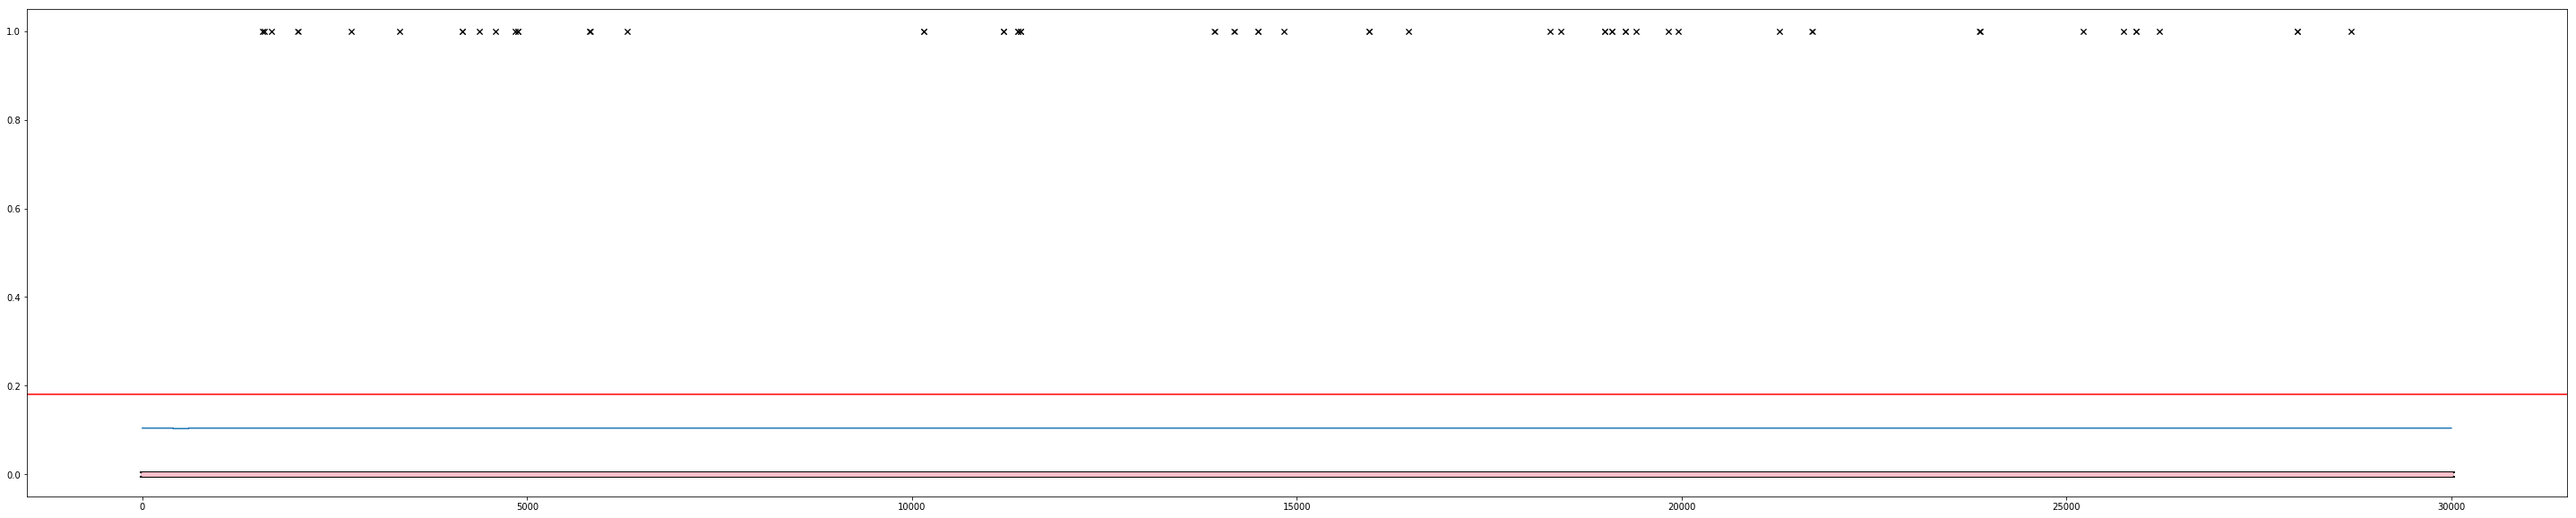

Correst Guess:  0
Total End Time:  309
Total Guess:  0


ZeroDivisionError: float division by zero

In [25]:
complete_evaluation_single_file(filename="TS3003a.Mix-Headset", hop=10, win_len=25, thres = 0.18, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="TS3012c.Mix-Headset", hop=10, win_len=25, thres = 0.18, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="TS3010a.Mix-Headset", hop=10, win_len=25, thres = 0.18, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="TS3010a.Mix-Headset", hop=10, win_len=25, thres = 0.18, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=False)

In [ ]:
complete_evaluation_single_file(filename="TS3010a.Mix-Headset", hop=10, win_len=25, thres = 0.18, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="EN2001b.Mix-Headset", hop=10, win_len=25, thres = 0.15, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="EN2001b.Mix-Headset", hop=10, win_len=25, thres = 0.15, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="EN2001b.Mix-Headset", hop=10, win_len=25, thres = 0.15, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="EN2001b.Mix-Headset", hop=10, win_len=25, thres = 0.15, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="EN2001b.Mix-Headset", hop=10, win_len=25, thres = 0.15, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="EN2001b.Mix-Headset", hop=10, win_len=25, thres = 0.15, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="EN2001b.Mix-Headset", hop=10, win_len=25, thres = 0.15, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="Lauschbuben_2015-03-06", hop=10, win_len=25, thres = 0.3, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
complete_evaluation_single_file(filename="Diverser_nicht_duemmer-Die_Unis_muessen_sich_auf_andere_Studenten_einstellen", hop=10, win_len=25, thres = 0.3, model=model, feature_extractor="yaafe",
                               sr=16000, featureplan = "featureplan_new.txt",
                               overlapping=True)

In [ ]:
## TO GET ALL RESULT FROM ALL CORPUS

precision_array = []
recall_array = []
f1_array = []
purity_array = []
coverage_array = []

corpus = os.listdir("/home/herdogan/Desktop/SpChangeDetect/df_media/")

for file in corpus:
    try:
        filename = file.split(".")[0]
        print (filename)
        
        precision, recall, f1, _, _ = complete_evaluation_single_file(filename, hop=10, win_len=25, feature_extractor="yaafe", model=model, show_graph_frame=False, thres=0.18, sr=16000, featureplan="featureplan_new.txt")
        precision_array.append(precision)
        recall_array.append(recall)
        f1_array.append(f1)
        
        
        
    except FileNotFoundError:
        print (filename + " is not in the directory")
        pass

In [ ]:
## TO GET ALL RESULT FROM ALL CORPUS

precision_array = []
recall_array = []
f1_array = []
purity_array = []
coverage_array = []

corpus = os.listdir("/home/herdogan/Desktop/SpChangeDetect/df_media/")

for file in corpus:
    try:
        filename = file.split(".")[0]
        print (filename)
        
        precision, recall, f1, _, _ = complete_evaluation_single_file(filename, hop=10, win_len=25, feature_extractor="yaafe", model=model, show_graph_frame=False, thres=0.16, sr=16000, featureplan="featureplan_new.txt", overlapping=True)
        precision_array.append(precision)
        recall_array.append(recall)
        f1_array.append(f1)
        
        
        
    except FileNotFoundError:
        print (filename + " is not in the directory")
        pass

In [ ]:
## TO GET ALL RESULT FROM ALL CORPUS

precision_array = []
recall_array = []
f1_array = []
purity_array = []
coverage_array = []

corpus = os.listdir("/home/herdogan/Desktop/SpChangeDetect/txt_ami_full/")

for file in corpus:
    try:
        filename = (file.split(".")[0]).split("_")[0]
        filename = filename + ".Mix-Headset"
        print (filename)
        
        precision, recall, f1, purity, coverage = complete_evaluation_single_file(filename, hop=10, win_len=25, feature_extractor="yaafe", model=model, show_graph_frame=False, thres=0.168, sr=16000, featureplan="featureplan_new.txt", overlapping=True)
        precision_array.append(precision)
        recall_array.append(recall)
        f1_array.append(f1)
        purity_array.append(purity)
        coverage_array.append(coverage)
        
    except FileNotFoundError:
        print (filename + " is not in the directory")
        pass

In [ ]:
corpus = os.listdir("/home/herdogan/Desktop/SpChangeDetect/amicorpus/*/")


In [ ]:
print(np.mean(precision_array))
print(np.mean(recall_array))
print(np.mean(f1_array))
print(np.mean(purity_array))
print(np.mean(coverage_array))

In [ ]:
corpus = os.listdir("/home/herdogan/Desktop/SpChangeDetect/df_media/")

for file in corpus:
    print ((file.split(".")[0])[:-4])
    new_file = ((file.split(".")[0])[:-4]) + ".wav" 
    !sox $file -r 16000 $new_file


### Create Subsequences with Label

At that point, we should create training and test data with their label. Also, we can use directly [pyannote.metrics](https://github.com/pyannote/pyannote-metrics)

### Deep Learning Architecture

We can directly upload the model's architecture from the .yml file which is provided by writer.

However, I want to directly write all steps.

In [ ]:
# Author's .yml files

!wget https://raw.githubusercontent.com/yinruiqing/change_detection/master/model/architecture.yml

In [ ]:
# Load to model

from keras.models import model_from_yaml
yaml_file = open('architecture.yml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)

In [ ]:
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [ ]:
import keras
print (keras.__version__)

In [ ]:
model.summary()

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.layers.advanced_activations import *
from keras.utils.generic_utils import get_custom_objects


frame_shape = (320, 35)

## Network Architecture

input_frame = keras.Input(frame_shape, name='main_input')

bidirectional_1 = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(input_frame)
bidirectional_2 = layers.Bidirectional(layers.LSTM(20, activation='tanh', return_sequences=True))(bidirectional_1)

tdistributed_1 = layers.TimeDistributed(layers.Dense(40, activation='tanh'))(bidirectional_2)
tdistributed_2 = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(tdistributed_1)
tdistributed_3 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(tdistributed_2)


# WE DO NOT NEED IT FOR TRAINING. SO DISCARD.
## Source: https://stackoverflow.com/questions/37743574/hard-limiting-threshold-activation-function-in-tensorflow
def step_activation(x):
    threshold = 0.4
    cond = tf.less(x, tf.fill(value=threshold, dims=tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))

    return out

# https://stackoverflow.com/questions/47034692/keras-set-output-of-intermediate-layer-to-0-or-1-based-on-threshold

step_activation = layers.Dense(1, activation=step_activation, name='threshold_activation')(tdistributed_3)



model = Model(input_frame, tdistributed_3)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer="rmsprop")

In [ ]:
model.summary()

In [ ]:
# To save our model

model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [ ]:
# To look our model

!cat model.yaml